# Wink 2016 Analysis
@author: Max Felius

## Paper Reference:
Kim, J. W., Lu, Z., & Degrandpre, K. (2016). Ongoing deformation of sinkholes in Wink, Texas, observed by time-series Sentinel-1A SAR interferometry (preliminary results). Remote Sensing, 8(4), 313.

## Sinkhole parameters from the paper:
- Results from the MSBAS processing indicate that the vertical deformation is the most dominant component in ground deformation around Wink sinkholes, ~80% of LOS InSAR measurements.
- Displays a maximum subsidence of ~4cm in four months.
- Maximum subsidence at a rate of up to ~13cm/year.
- Deformation present already since 2009.
- extent of the subsidence area has increased. 

## Model Fit Parameters:
- Model: Okada, Y. (1985). Surface deformation due to shear and tensile faults in a half-space. Bulletin of the seismological society of America, 75(4), 1135-1154.
- Simple elastic displacement (cavity roof deflation), homogeneous elastic half space
- Source at 500 meter depth
- Two-source model; source one 120 x 10m and source two 80 x 10 meter

![](Wink2016.png)

## Analyse
- Apply inverse kinematic model using Gaussian Influence function and linear time. Estimate v(t) and R. Determine fit by RMS and Percentage of Model description; $100 \cdot (1 - \frac{\sum |\hat{e}|}{\sum|y|})$.
- Test Different influence functions
- Test Mogi Model

### References
https://pubs.geoscienceworld.org/jeeg/article-abstract/17/2/75/139408 <br>
https://www.tandfonline.com/doi/full/10.1080/19475701003648077 <br>
https://pubs.geoscienceworld.org/ssa/bssa/article-abstract/75/4/1135/118782/Surface-deformation-due-to-shear-and-tensile?redirectedFrom=fulltext

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time, os
import datetime
import re

In [2]:
#defining the different influence functions
def zg(R,r,itype='gaus'):
    '''
    Automatically uses the Gaussian Influence Function unless specified differently
    '''
    if itype == 'gaus':
        return -zg_gaus(R,r)
    elif itype == 'bals':
        return -zg_bals(R,r)
    elif itype == 'beyer':
        return -zg_beyer(R,r)
    else:
        print(f'Unknown itype: {itype}.')

def zg_gaus(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))

def zg_bals(H,r):
#     r = np.sqrt((x-x0)**2 + (y-y0)**2)
    zone = np.arctan(r/H)
    return 1*(1/(1+r**2))*np.cos(zone)**2

def zg_beyer(R,r):
#     r = np.sqrt((x-x0)**2 + (y-y0)**2)
    kz = ((3)/(np.pi*R**2))*(1-(r/R)**2)**2
    kz[r>R] = 0
    return kz

## Inverse Kinematic Model

Solve nonlinear Least Squares using the Gauss-Newton Method

In [3]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
#         print(f'Beginning iteration {i+1}...')
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
            print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
    if i == n-1:
        print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
    print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R

## Least Squares

In [31]:
def least_squares(t,R,r,y):
    '''
    Normal Least Squares
    '''
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    A = np.array([t*zg(R,r)]).T
    
    Qxhat = np.linalg.inv(A.T @ invQyy @ A)
    
    xhat = Qxhat @ A.T @ invQyy @ y
    
    return xhat

In [5]:
data_folder = 'Wink2016'

start_date = '20150421'
start_date_datetime = datetime.datetime.strptime(start_date,'%Y%m%d')
date_list = []
delta_days = []
data_list = []

for date in os.listdir(data_folder):
    if date.endswith('.csv'):
        #get the date from the title
        m = re.search(r'\d{8}',date)
        date_conv = datetime.datetime.strptime(m.group(0),'%Y%m%d')
        date_list.append(date_conv)

        #Determine the number of days since the start date
        delta_days.append((date_conv-start_date_datetime).days)

        #Read the data from the files
        data_list.append(pd.read_csv(os.path.join(data_folder,date),header=None))

In [40]:
#extract x and z coordinates and define t
x = np.array([])
y = np.array([])
t = np.array([])
nitems = 0
for idx,item in enumerate(data_list):
    nitems += 1
    n = len(item)
    t = np.concatenate((t,[delta_days[idx]]*n))
    x = np.concatenate((x,item[0].values))
    y = np.concatenate((y,item[1].values))

# y = y/100 #convert from cm to meters    

#define r
x0 = 480 #observed from the graph
r = np.sqrt((x-x0)**2)


In [41]:
R = 480

V = least_squares(t,R,r,y)

print(V,120*V,R*R)

[7724.94479242] [926993.37509017] 230400


In [43]:
v_in = 1000
R_in = 470

v, R = inverse_kinematic_model(v_in,t,R_in,r,y)

# print(v,R)

Stopped at iteration 22.
The computed values are v=9578.920335026261 and R=553.0609564207198.
The total runtime was: 0.016663551330566406 seconds.


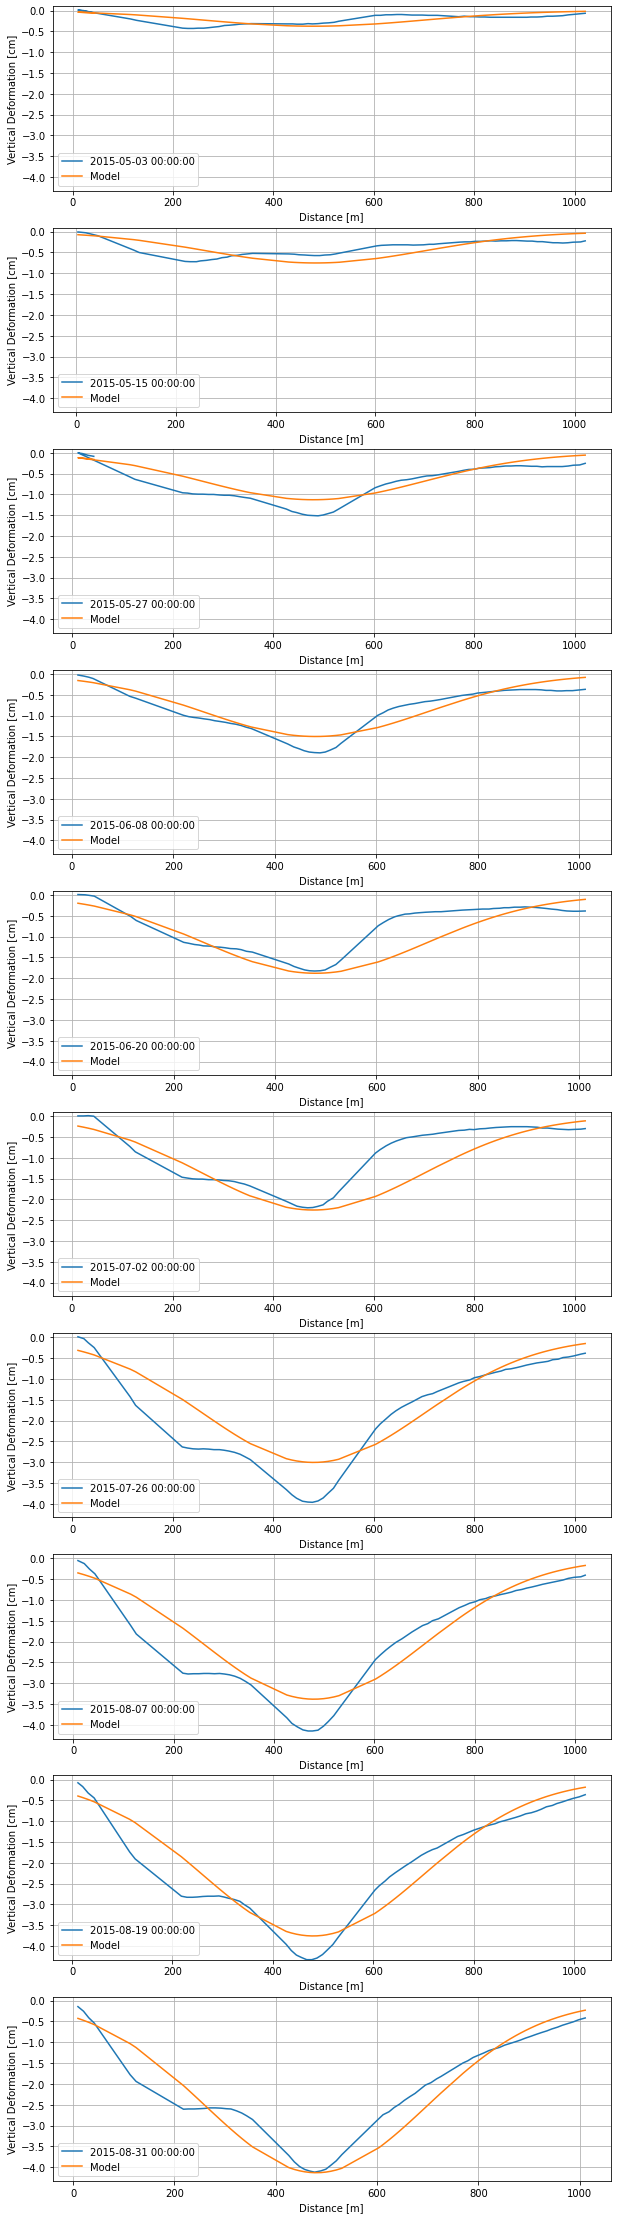

In [44]:
#plot the results

# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(nrows=nitems, figsize = (10,40))
zmin = min(data_list[-2][1])

for i in range(nitems):
    ax[i].plot(data_list[i][0].values,data_list[i][1].values,label=date_list[i])
    
    x1 = data_list[i][0].values
    
    r1 = np.sqrt((x1-x0)**2)
    y1 = v*delta_days[i]*zg(R,r1)
#     print(delta_days[i],v*delta_days[i],zg(R,r1))
    ax[i].plot(x1,y1,label='Model')
    
    ax[i].grid(True)
    ax[i].set_xlabel('Distance [m]')
    ax[i].set_ylabel('Vertical Deformation [cm]')
    ax[i].set_ylim(zmin,0.1)
#     ax[i].set_title(f'{date_list[i]}')
    ax[i].legend()
